In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# import torchvision.transforms as transforms
import torchsummary
from tqdm import tqdm
import torchvision.models as models  # Add this import for pre-trained models


In [3]:
# 1) GPU？
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# <1> 数据预处理
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((224, 224)), torchvision.transforms.ToTensor()]
)

# <2> 加载MNIST数据集
dataset = torchvision.datasets.ImageFolder(root="/mnt/workspace/data/ImageNet-10", transform=transform)
train_size = int(0.8 * len(dataset))  # 训练集占80%，1,300张*0.8=1040张
test_size = len(dataset) - train_size  # 测试集占20%，1,300张-1040张=260张
torch.manual_seed(42)  # 为了保证每次划分的数据集一致
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)


Using cuda device


In [4]:
# <3> 定义ResNet34模型
resnet34 = models.resnet34()  # 加载预训练的ResNet34模型
# 修改最后的全连接层以适应10个类别
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, 10)
# 将模型移动到GPU
resnet34 = resnet34.to(device)  # 2) 将模型加载到GPU上

# torchsummary
torchsummary.summary(resnet34, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [5]:
# <4> 损失函数
criterion = nn.CrossEntropyLoss()

# <5> 优化器
optimizer = optim.Adam(resnet34.parameters(), lr=0.0001)

In [6]:
# <6> 自定义计算准确率函数
def test(model, testloader):
    # <6-1> 进入评估模式
    model.eval()

    # <6-2> 计算输出
    correct = total = 0
    with torch.no_grad():  # 关闭梯度计算
        # 从测试集中一批一批地取数据, 每批64个, 一共取260/64=4次+1次
        for images, labels in testloader:

            # 4) 将测试数据加载到GPU上
            images, labels = images.to(device), labels.to(device)

            # 计算预测值
            outputs = model(images)

            # <6-3> 计算准确率
            # 按行(=1)取最大值，返回最大值、最大值的索引(预测结果)
            _, predicted = torch.max(outputs.data, 1)

            # 预测值与真实值比较后, 再求和
            correct += (predicted == labels).sum().item()
            # 测试集总数
            total += labels.size(0)

    # 准确率
    accuracy = correct / total

    # 返回：准确率
    return accuracy

In [6]:
# <7> 训练模型
# 初始化训练过程中的指标：训练精度、测试精度、损失，用于绘图
train_acc_history, test_acc_history, loss_history = [], [], []

print("Total number of images for training: ", len(trainset))

for epoch in range(10):  # 训练10个epoch
    resnet34.train()
    epoch_loss = 0.0  # 每epoch的损失
    running_loss = 0.0  # 每64批次batch的损失

    # 从0开始计数，每次取一个batch，一共取10400/16=650次
    for i, data in enumerate(trainloader, 0):
        X_train, y_train = data

        # 3) 将训练数据加载到GPU上
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        outputs = resnet34(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        running_loss += loss.item()

        # 每100个batch打印一次损失
        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.8f}")
            running_loss = 0.0

    # 更新绘图指标
    train_acc_history.append(test(resnet34, trainloader))
    test_acc_history.append(test(resnet34, testloader))
    loss_history.append(epoch_loss / len(trainloader))
    print(
        f"Epoch {epoch + 1} loss: {epoch_loss / len(trainloader):.8f}, train accuracy: {train_acc_history[-1]:.3%}, test accuracy: {test_acc_history[-1]:.3%}"
    )

# 清空CUDA缓存
torch.cuda.empty_cache()

# 打印CUDA内存使用情况
print(f"CUDA memory allocated: {torch.cuda.memory_allocated(device) / 1024**2:.0f} MB")

print("Finished Training")

Total number of images for training:  10404
[Epoch 1, Batch 100] loss: 1.92539667
[Epoch 1, Batch 200] loss: 1.59629122
[Epoch 1, Batch 300] loss: 1.38646147
[Epoch 1, Batch 400] loss: 1.27830527
[Epoch 1, Batch 500] loss: 1.20257802
[Epoch 1, Batch 600] loss: 1.05444316
Epoch 1 loss: 1.38180789, train accuracy: 65.542%, test accuracy: 64.566%
[Epoch 2, Batch 100] loss: 0.95414820
[Epoch 2, Batch 200] loss: 0.91719798
[Epoch 2, Batch 300] loss: 0.99475613
[Epoch 2, Batch 400] loss: 0.87600402
[Epoch 2, Batch 500] loss: 0.87672784
[Epoch 2, Batch 600] loss: 0.86737907
Epoch 2 loss: 0.90988195, train accuracy: 72.501%, test accuracy: 70.638%
[Epoch 3, Batch 100] loss: 0.77158078
[Epoch 3, Batch 200] loss: 0.77792962
[Epoch 3, Batch 300] loss: 0.70498693
[Epoch 3, Batch 400] loss: 0.72783033
[Epoch 3, Batch 500] loss: 0.69580693
[Epoch 3, Batch 600] loss: 0.72797805
Epoch 3 loss: 0.73385561, train accuracy: 80.613%, test accuracy: 77.133%
[Epoch 4, Batch 100] loss: 0.60655003
[Epoch 4, Ba

In [14]:
torch.save(resnet34.state_dict(), "/mnt/workspace/resnet34_weights.pth")

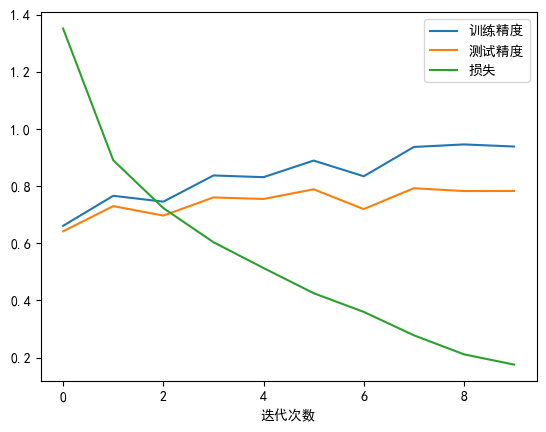

最终训练精度: 93.87%
最终测试精度: 78.31%


In [7]:
# <8> 绘制训练过程中的指标
import matplotlib.pyplot as plt
from matplotlib import rcParams  # 设置全局参数，为了设置中文字体


# 定义绘制函数
def draw_plot(train_acc_history, test_acc_history, loss_history):
    rcParams["font.family"] = "simHei"  # 设置中文黑体字
    plt.figure()
    plt.plot(train_acc_history, label="训练精度")
    plt.plot(test_acc_history, label="测试精度")
    plt.plot(loss_history, label="损失")
    plt.legend()  # 显示图例
    plt.xlabel("迭代次数")
    plt.show()


draw_plot(train_acc_history, test_acc_history, loss_history)
print(f"最终训练精度: {train_acc_history[-1]:.2%}")
print(f"最终测试精度: {test_acc_history[-1]:.2%}")

In [1]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models

# 打开图像文件
image_path = "/mnt/workspace/data/鸡.jpg"
image_path_peng = "/mnt/workspace/data/企鹅.jpg"
image = Image.open(image_path)
image_peng = Image.open(image_path_peng)

# 转换图像模式
if image.mode == 'RGBA':
    image = image.convert('RGB')
if image_peng.mode == 'RGBA':  # 修复此处变量名错误
    image_peng = image_peng.convert('RGB')  # 正确转换为企鹅图像的RGB模式

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 处理第一个图像
input_tensor1 = transform(image)
input_batch1 = input_tensor1.unsqueeze(0)  # 添加batch维度 [1, 3, 224, 224]

# 处理第二个图像
input_tensor2 = transform(image_peng)
input_batch2 = input_tensor2.unsqueeze(0)  # 添加batch维度

# 加载模型（使用新式参数）
# 确保加载的是训练后的权重，而不是预训练权重
# 确保加载的是训练后的权重，而不是预训练权重
# 使用预训练权重
resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
resnet34.eval()
resnet34.eval()


# 分别进行预测
with torch.no_grad():
    output1 = resnet34(input_batch1)
    output2 = resnet34(input_batch2)

# 获取并打印结果
_, predicted1 = torch.max(output1, 1)
_, predicted2 = torch.max(output2, 1)
print(f"鸡的预测类别: {predicted1.item()}")
print(f"企鹅的预测类别: {predicted2.item()}")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [01:16<00:00, 1.14MB/s]


鸡的预测类别: 7
企鹅的预测类别: 145


In [13]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models

# 打开图像文件
image_path = "/mnt/workspace/data/鸡.jpg"
image_path_peng = "/mnt/workspace/data/企鹅.jpg"
image = Image.open(image_path)
image_peng = Image.open(image_path_peng)

# 转换图像模式
if image.mode == 'RGBA':
    image = image.convert('RGB')
if image_peng.mode == 'RGBA':  # 修复此处变量名错误
    image_peng = image_peng.convert('RGB')  # 正确转换为企鹅图像的RGB模式

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 处理第一个图像
input_tensor1 = transform(image)
input_batch1 = input_tensor1.unsqueeze(0)  # 添加batch维度 [1, 3, 224, 224]

# 处理第二个图像
input_tensor2 = transform(image_peng)
input_batch2 = input_tensor2.unsqueeze(0)  # 添加batch维度

# 加载模型（使用新式参数）
# 确保加载的是训练后的权重，而不是预训练权重
# 确保加载的是训练后的权重，而不是预训练权重
# 使用预训练权重
resnet34 = models.resnet34()
num_ftrs = resnet34.fc.in_features
resnet34.fc = torch.nn.Linear(num_ftrs, 10)  # 修改为 10 类
resnet34.load_state_dict(torch.load("/mnt/workspace/resnet34_weights.pth"))
resnet34.eval()


# 分别进行预测
with torch.no_grad():
    output1 = resnet34(input_batch1)
    output2 = resnet34(input_batch2)

# 获取并打印结果
_, predicted1 = torch.max(output1, 1)
_, predicted2 = torch.max(output2, 1)
print(f"鸡的预测类别: {predicted1.item()}")
print(f"企鹅的预测类别: {predicted2.item()}")

鸡的预测类别: 6
企鹅的预测类别: 6
